## GRUPO 8 

#### *Integrantes:* 

1. Gianfranco Soria (20163509)
3. Andrea Clavo (20176040)
4. Sandra Martínez (20173026)

# Question 1

### 1. Causal Forest 

You have to replicate the results found in the paper of Athey and Wager (2018) . I want to help you so I already found the steps you should follow to replicate this, check this repo and use the code in there.
Please describe in detail the results you found in the next sections of the code:

1. How the tree was built?
2. Estimate ATE
3. Run best linear predictor analysis
4. Look at school-wise heterogeneity
5. Analysis ignoring clusters. How do the results change?
6. Analysis without fitting the propensity score
7. The code plot six plots in the Make some plots section, so explain what you find there.
8. Visualize school-level covariates by treatment heterogeneity
9. CATE by school

In [1]:
install.packages("Hmisc")
install.packages('grf')

also installing the dependencies 'png', 'jpeg', 'viridisLite', 'survival', 'latticeExtra', 'gridExtra', 'htmlTable', 'viridis'




  There are binary versions available but the source versions are later:
           binary source needs_compilation
jpeg      0.1-8.1  0.1-9              TRUE
survival   3.2-11 3.2-13              TRUE
htmlTable   2.1.0  2.3.0             FALSE
viridis     0.6.1  0.6.2             FALSE
Hmisc       4.5-0  4.6-0              TRUE

  Binaries will be installed
package 'png' successfully unpacked and MD5 sums checked
package 'jpeg' successfully unpacked and MD5 sums checked
package 'viridisLite' successfully unpacked and MD5 sums checked
package 'survival' successfully unpacked and MD5 sums checked
package 'latticeExtra' successfully unpacked and MD5 sums checked
package 'gridExtra' successfully unpacked and MD5 sums checked
package 'Hmisc' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\sandr\AppData\Local\Temp\RtmpCsegbm\downloaded_packages


installing the source packages 'htmlTable', 'viridis'

also installing the dependencies 'DiceKriging', 'RcppEigen'




  There is a binary version available but the source version is later:
    binary source needs_compilation
grf  1.2.0  2.0.2              TRUE

  Binaries will be installed
package 'DiceKriging' successfully unpacked and MD5 sums checked
package 'RcppEigen' successfully unpacked and MD5 sums checked
package 'grf' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\sandr\AppData\Local\Temp\RtmpCsegbm\downloaded_packages


In [2]:
set.seed(1)

rm(list = ls())

library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}

library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

Warning message:
"package 'grf' was built under R version 3.6.3"Warning message:
"package 'lmtest' was built under R version 3.6.3"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'Hmisc' was built under R version 3.6.3"Loading required package: lattice
Loading required package: survival
Warning message:
"package 'survival' was built under R version 3.6.3"Loading required package: Formula
Warning message:
"package 'Formula' was built under R version 3.6.3"Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'Hmisc'

The following objects are masked from 'package:base':

    format.pval, units



In [8]:
data.all = read.csv("synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)
school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

In [9]:
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [10]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)

In [11]:
# Grow a forest. Add extra trees for the causal forest.

Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions

In [12]:
# Estimate ATE

ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.249 +/- 0.04"

In [13]:
# Run best linear predictor analysis
test_calibration(cf)

# Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                                Estimate Std. Error t value Pr(>t)    
mean.forest.prediction          1.008054   0.082129 12.2741 <2e-16 ***
differential.forest.prediction -0.552783   1.063927 -0.5196 0.6983    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "95% CI for difference in ATE: 0.01 +/- 0.074"

In [14]:
# Formal test for X1 and X2

dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])

school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])

school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0347, df = 71.45, p-value = 0.003357
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19218352 -0.03978437
sample estimates:
mean of x mean of y 
0.1908525 0.3068365 



	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 0.9637, df = 72.286, p-value = 0.3384
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04146936  0.11909811
sample estimates:
mean of x mean of y 
0.2682517 0.2294373 


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0811 0.04054   1.328  0.271
Residuals        73 2.2283 0.03052               


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.2397, df = 75, p-value = 0.02807
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.009408619 0.160803922
sample estimates:
 mean of x 
0.08510627 


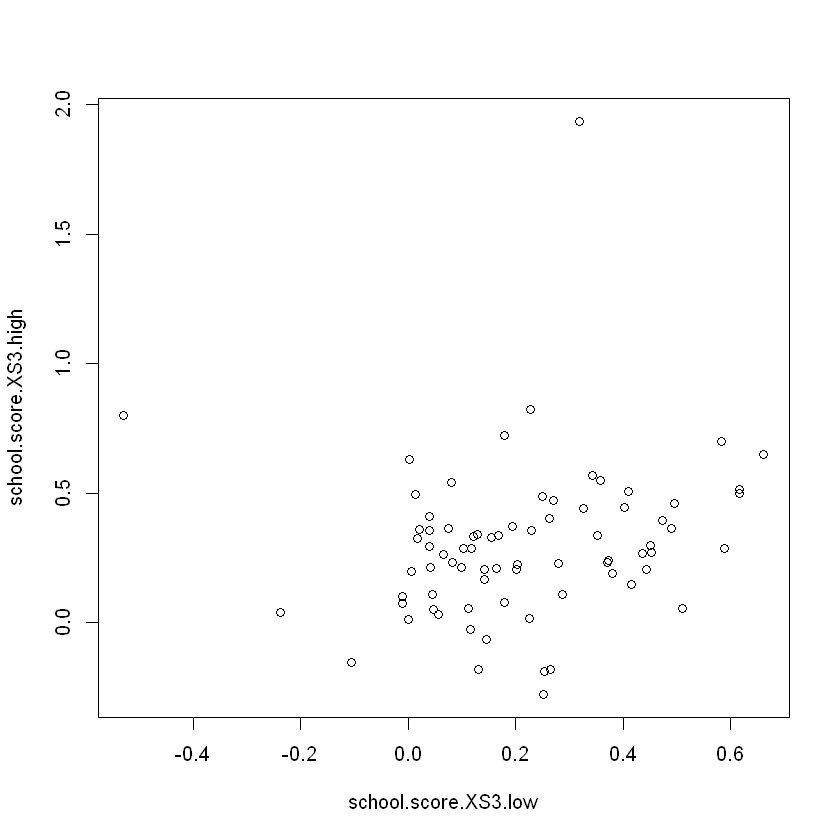

In [15]:
# Formal test for S3

school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)

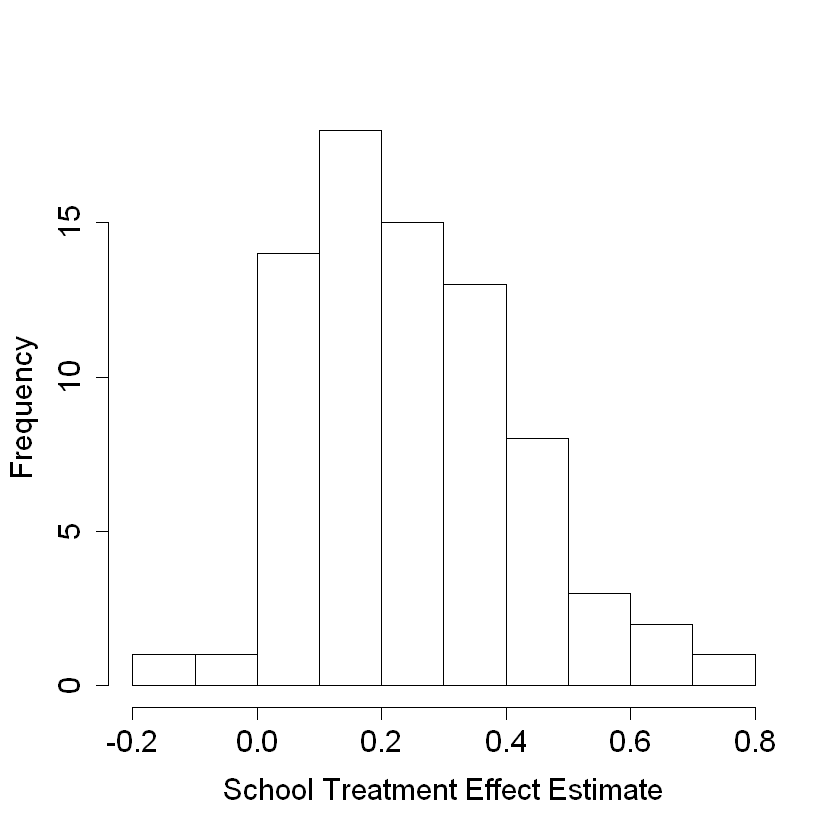

In [16]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")

In [17]:
# Re-check ATE... sanity check only

ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.249 +/- 0.039"


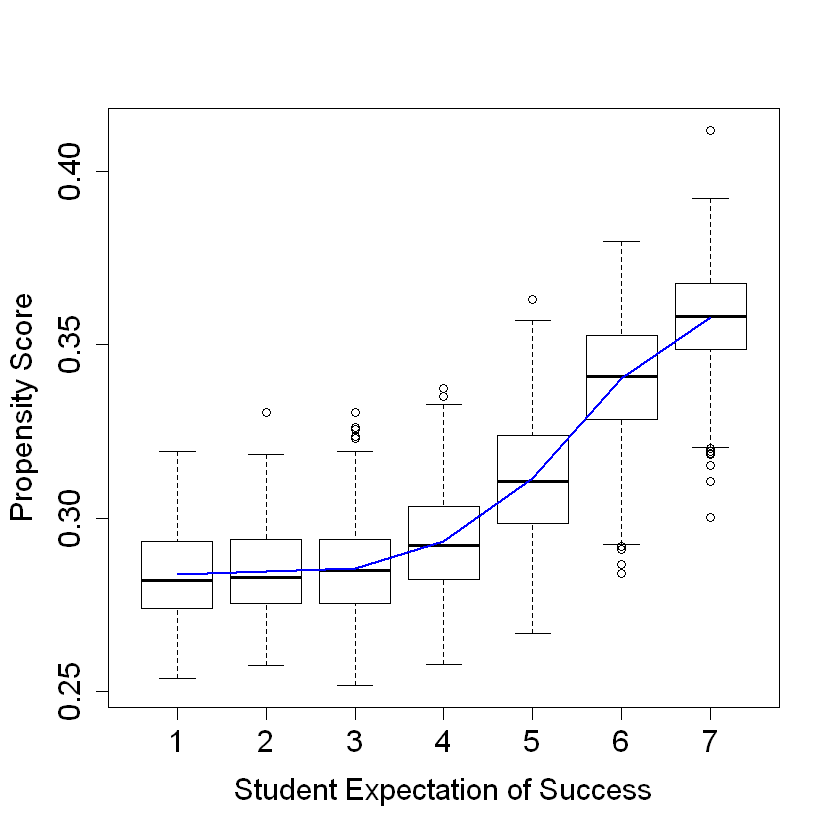

In [18]:
# Look at variation in p - scores

DF = X
DF$W.hat = cf$W.hat
 
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)

[1] "95% CI for the ATE: 0.254 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.012757   0.045084 22.4639 < 2.2e-16 ***
differential.forest.prediction 0.528275   0.133245  3.9647 3.699e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.988134   0.064817 15.2450 <2e-16 ***
differential.forest.prediction 0.224634   0.213643  1.0514 0.1465    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] -8.914985e-05  5.040540e-04

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    201   2.677    1.98 1.05e-06 ***
Residuals         10315  13944   1.352                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

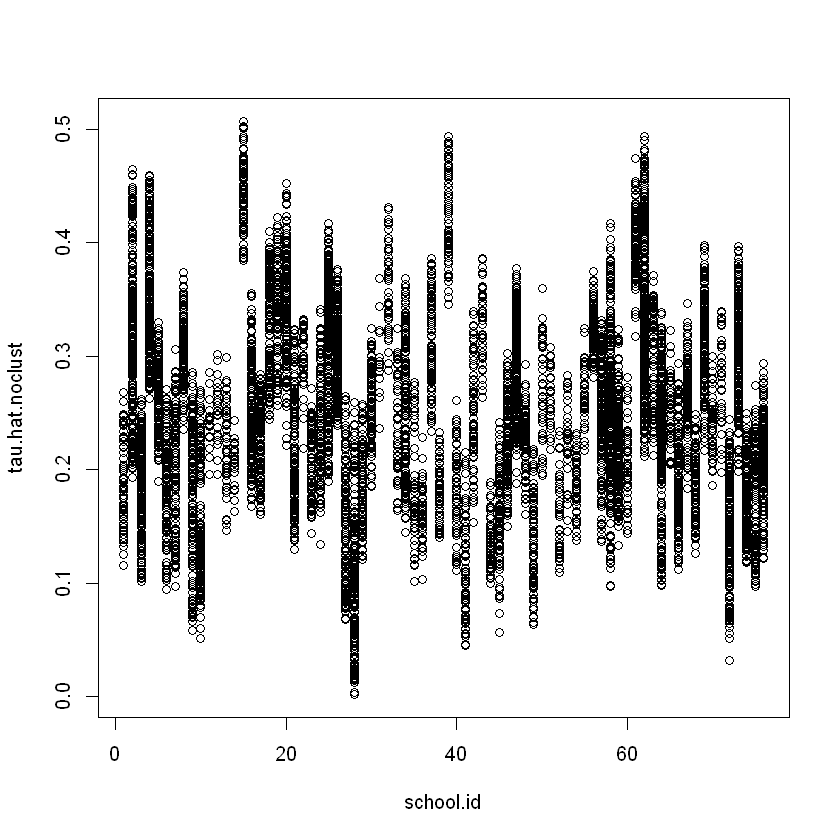

In [19]:
# Analysis ignoring clusters

cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))

[1] "95% CI for the ATE: 0.255 +/- 0.041"

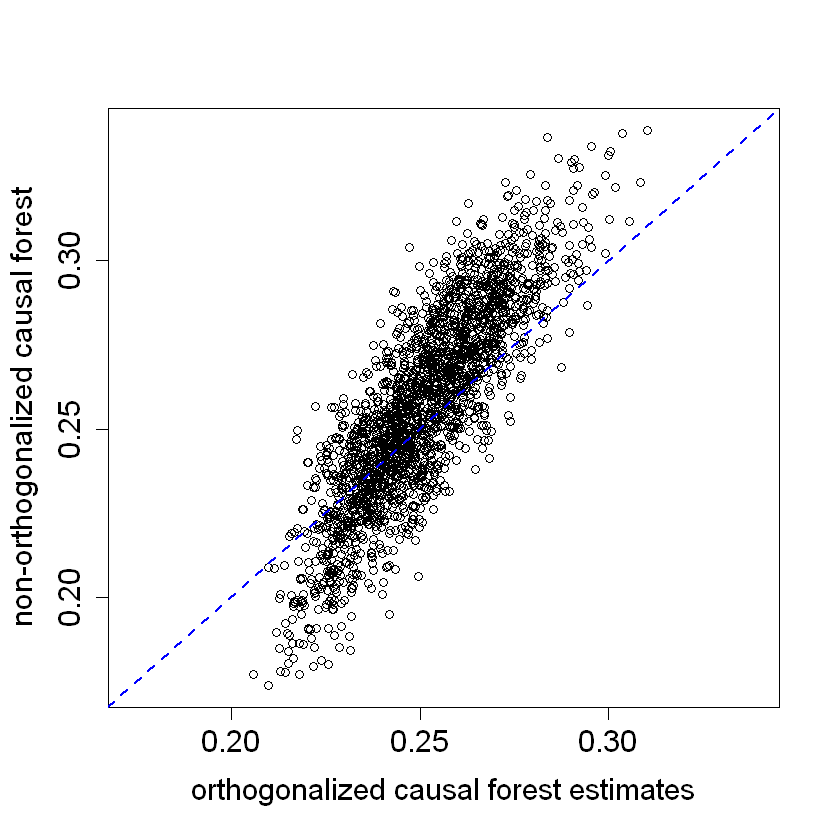

In [20]:
# Analaysis without fitting the propensity score
 
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))
 
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef 

In [21]:
# Train forest on school-wise DR scores

school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction          1.00004    0.08179 12.2269 <2e-16 ***
differential.forest.prediction  0.71717    0.67983  1.0549 0.1474    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [22]:
# Alternative OLS analysis 

school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2414116  0.0770612  3.1327 0.002583 **
X1          -0.0506340  0.0291568 -1.7366 0.087121 . 
X2           0.0125656  0.0336563  0.3734 0.710084   
X3           0.0102119  0.0266019  0.3839 0.702302   
X4           0.0236645  0.0255092  0.9277 0.356950   
X5          -0.0357828  0.0268560 -1.3324 0.187312   
XC.1         0.0015231  0.0935067  0.0163 0.987054   
XC.2         0.0887259  0.1047433  0.8471 0.400012   
XC.3        -0.1341513  0.0875327 -1.5326 0.130158   
XC.4         0.0424028  0.0816170  0.5195 0.605127   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


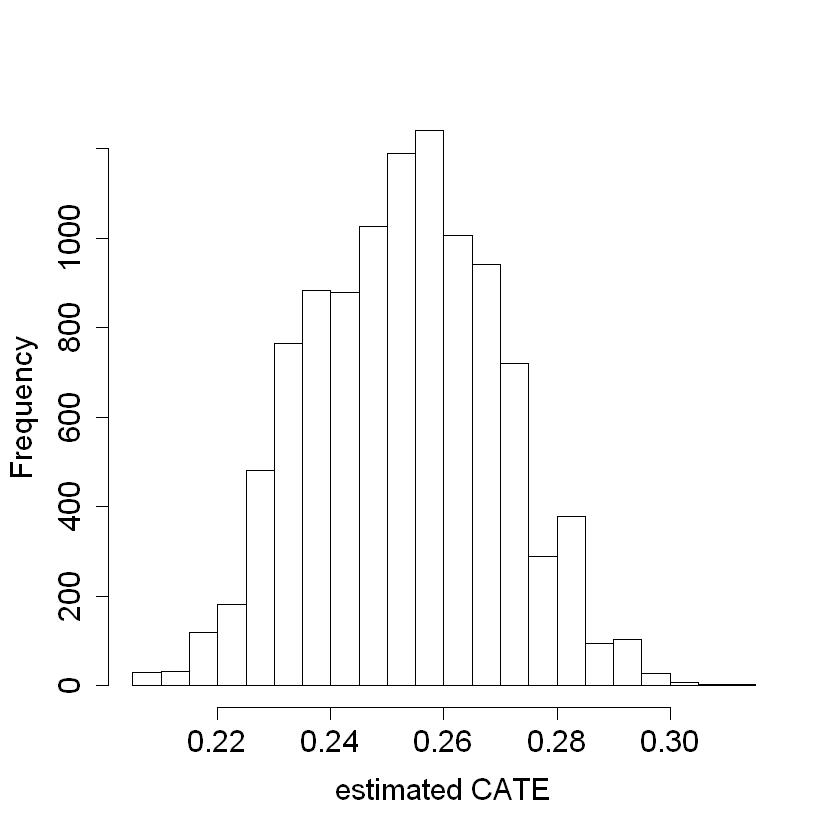

In [23]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")

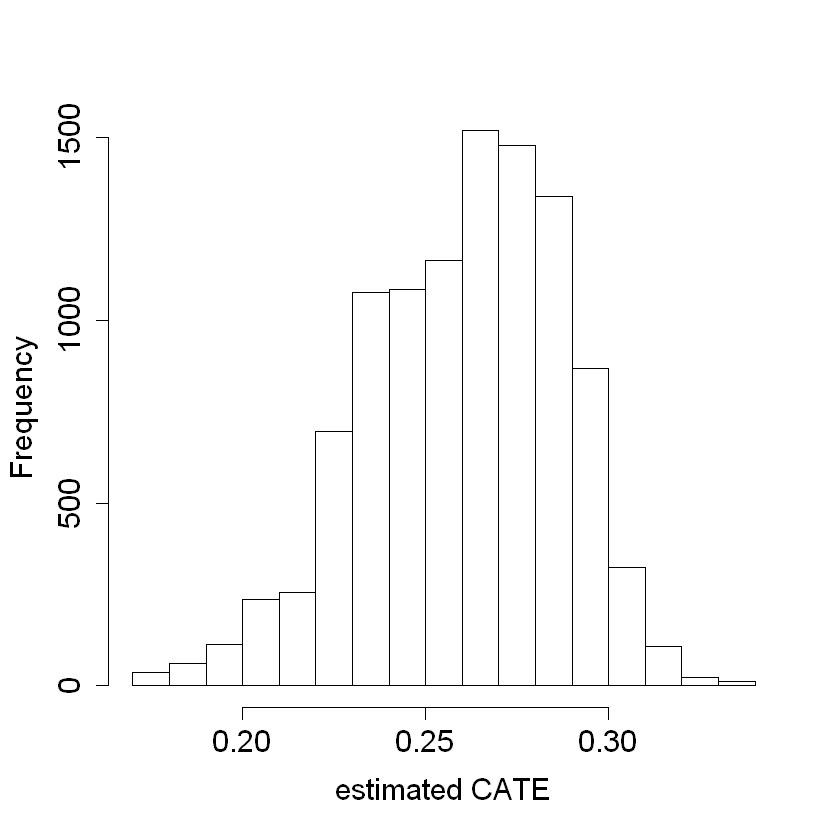

In [24]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")

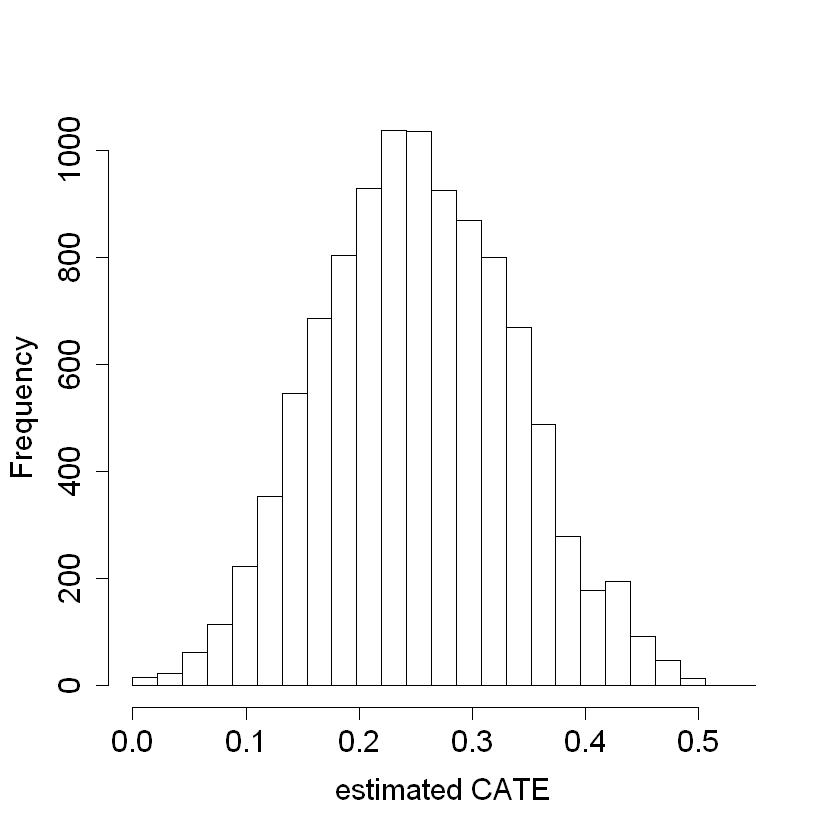

In [25]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "", breaks = seq(-0.0, 0.55, by = 0.55 /25 ))

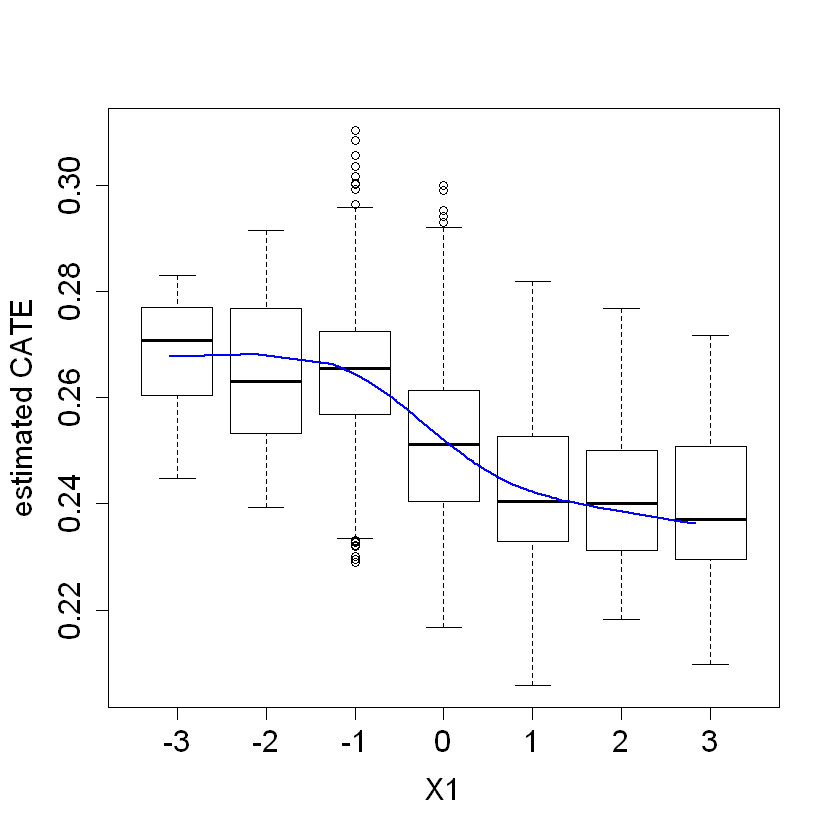

In [26]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)

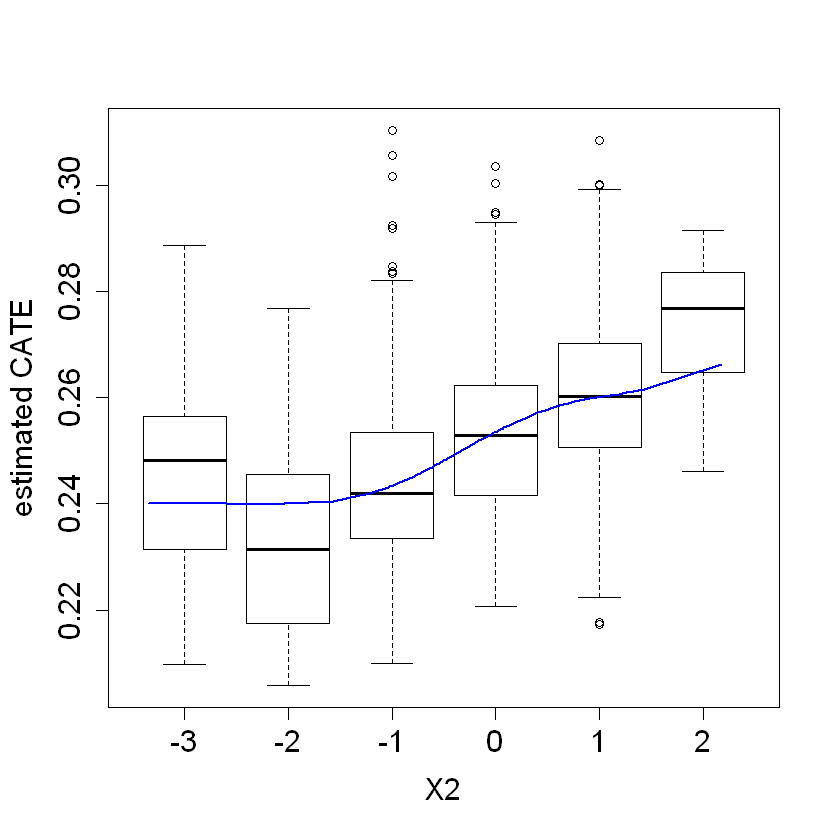

In [27]:
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)

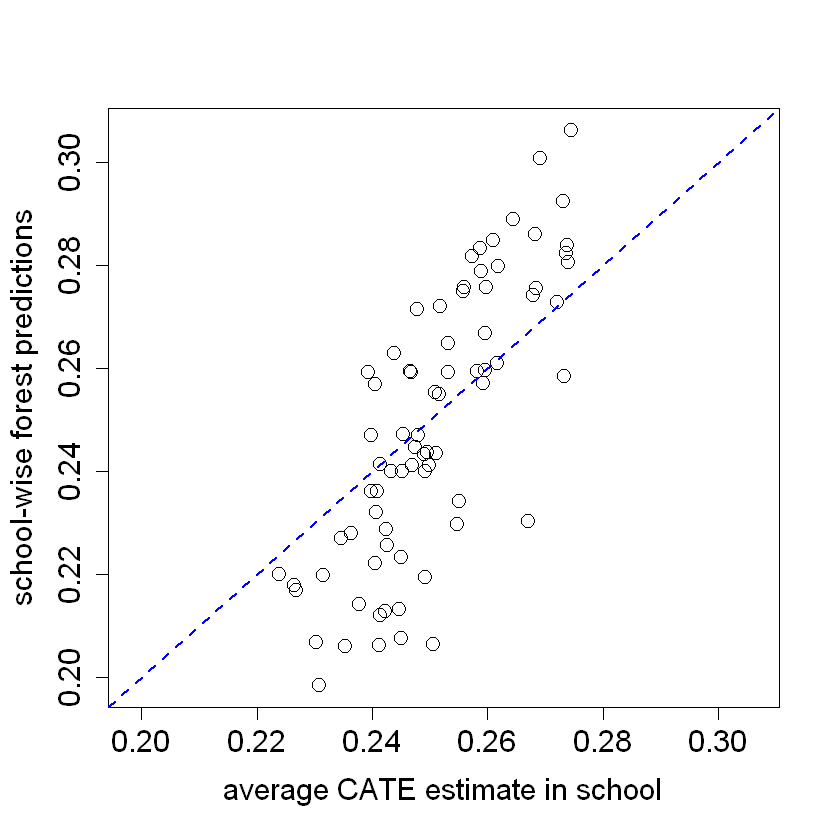

In [28]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size
 
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab = 1.5, cex.axis = 1.5, cex.main = 1.5, cex.sub = 1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef

In [29]:
# Experiment with no orthogonalization

n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: 0.01 +/- 0.15"

[1] "95% CI for the ATE: 0.13 +/- 0.137"

[1] 0.2105263

[1] 0.5384615

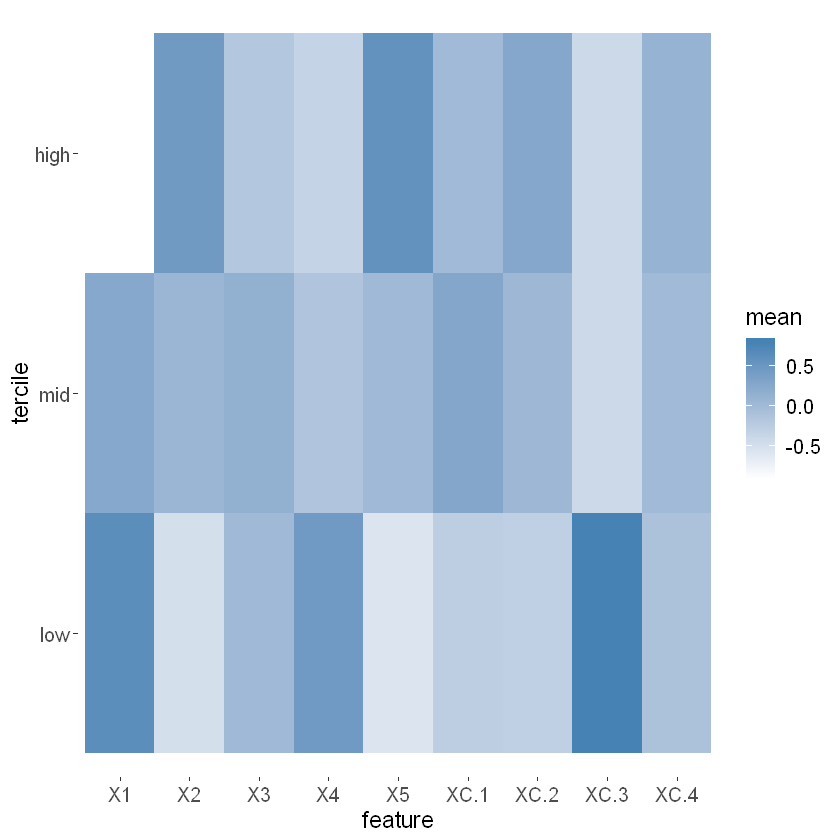

In [30]:
# Visualize school-level covariates by treatment heterogeneity

school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

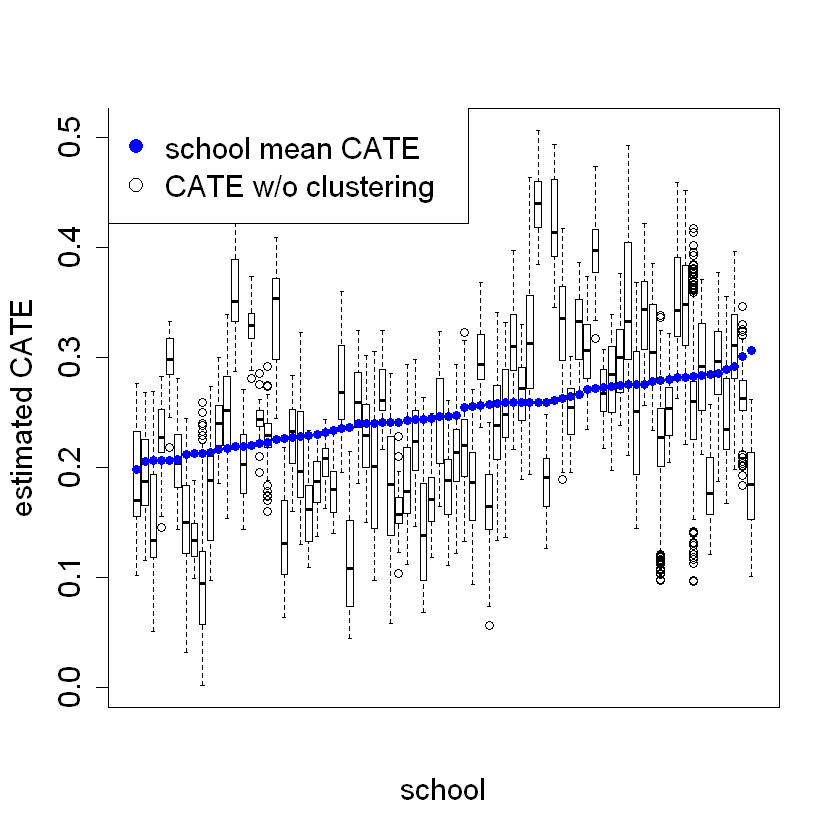

In [31]:
# CATE by school

ord = order(order(school.pred))
school.sort = ord[school.id]
 
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef

# Question 2

# A Case Study: The Effect of initial wealth on growth rate

We consider the problem of estimating the effect of initial wealth on growth rate for different countries. For this purpose, we estimate the following partially linear model.

$$
 Y_{j,t} = \beta D_{j,(t-1)} + g(Z_{j,t}) + \epsilon_{j,t}.
$$

## Data

In [1]:
#Install necessary packages and libraries
#install.packages("rio")
library(rio)

# Import data: 
rdata<-import("C:/Users/PC-1/Documents/GitHub/ECO224/labs/data/GrowthData.RData")
head(rdata)

Outcome,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
-0.02433575,1,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
0.10047257,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
0.06705148,1,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
0.06408917,1,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
0.02792955,1,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283
0.04640744,1,7.218910,0.0000,0.258865,0.020880,0.023,0.038,0.006,0.50,...,1.46,0.160,0.174,0.146,34.3,8.1,0.0634,0.0762,1.000,-0.001747


In [2]:
names(rdata)

[1] "Outcome"   "intercept" "gdpsh465"  "bmp1l"     "freeop"    "freetar"  
 [7] "h65"       "hm65"      "hf65"      "p65"       "pm65"      "pf65"     
[13] "s65"       "sm65"      "sf65"      "fert65"    "mort65"    "lifee065" 
[19] "gpop1"     "fert1"     "mort1"     "invsh41"   "geetot1"   "geerec1"  
[25] "gde1"      "govwb1"    "govsh41"   "gvxdxe41"  "high65"    "highm65"  
[31] "highf65"   "highc65"   "highcm65"  "highcf65"  "human65"   "humanm65" 
[37] "humanf65"  "hyr65"     "hyrm65"    "hyrf65"    "no65"      "nom65"    
[43] "nof65"     "pinstab1"  "pop65"     "worker65"  "pop1565"   "pop6565"  
[49] "sec65"     "secm65"    "secf65"    "secc65"    "seccm65"   "seccf65"  
[55] "syr65"     "syrm65"    "syrf65"    "teapri65"  "teasec65"  "ex1"      
[61] "im1"       "xr65"      "tot1"

In [3]:
# Outcome variable statistics
summary(rdata$Outcome)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.10099  0.02104  0.04621  0.04535  0.07403  0.18553 

In [4]:
# Treatment variable statistics
summary(rdata$gdpsh465) 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  5.762   7.132   7.726   7.703   8.442   9.230 

In [5]:
# Treatment Variable
d     <- "gdpsh465"

# Outcome Variable
y     <- "Outcome"

# Treatment Variable
D     <- rdata[which(colnames(rdata) == "gdpsh465")]

# Outcome Variable
Y     <- rdata[which(colnames(rdata) == "Outcome")]

# Construct matrix Z

Z     <- rdata[,-c(which(colnames(rdata)=="Outcome"),which(colnames(rdata)=="gdpsh465"),which(colnames(rdata)=="intercept"))]

## The effect of initial wealth

### OLS

After preprocessing the data, we first look at simple regression of $Y_{j,t}$ on $D_{j,t-1}$ without controls as a baseline model.

#### - OLS without including the country characteristics

In [6]:
baseline_formula <- as.formula(paste(y, "~", d ))
simple.ols <- lm(baseline_formula,data=rdata)

In [8]:
est_simple.ols <- summary(simple.ols)$coef[2,]
confint(simple.ols)[2,]
est_simple.ols

2.5 %      97.5 % 
-0.01081013  0.01344355

Estimate  Std. Error     t value    Pr(>|t|) 
0.001316713 0.006102200 0.215776701 0.829661165

#### - OLS including the country characteristics

In [49]:
control_formula <- as.formula(paste(y, "~", paste(d,paste(colnames(Z),collapse="+"),
                                                          sep="+")))
full.ols <- lm(control_formula,data=rdata)

In [50]:
est_ols <- summary(full.ols)$coef[2,]
confint(full.ols)[2,]
est_ols

2.5 %      97.5 % 
-0.07060022  0.05184424

Estimate   Std. Error      t value     Pr(>|t|) 
-0.009377989  0.029887726 -0.313773911  0.756018518

In [51]:
summary(full.ols)$coef

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.247160893,0.78450163,0.31505466,0.755056170
gdpsh465,-0.009377989,0.02988773,-0.31377391,0.756018518
bmp1l,-0.068862679,0.03253065,-2.11685513,0.043289718
freeop,0.080068974,0.20786400,0.38519885,0.703000838
freetar,-0.488962605,0.41816285,-1.16931143,0.252136477
h65,-2.362098638,0.85729167,-2.75530338,0.010192435
hm65,0.707143400,0.52314511,1.35171560,0.187285919
hf65,1.693448425,0.50318881,3.36543337,0.002232683
p65,0.265526695,0.16429407,1.61616729,0.117271229
pm65,0.136952626,0.15121749,0.90566657,0.372840111


We can notice that in both models the variable "gdpsh465" turns out to be non-significant. If we ignore this fact, it can be noted that there is a sign change.

## DML algorithm

Here we perform inference of the predictive coefficient $\beta$ in our partially linear statistical model, 

$$
Y = D\beta + g(Z) + \epsilon, \quad E (\epsilon | D, Z) = 0,
$$

using the **double machine learning** approach. 

For $\tilde Y = Y- E(Y|Z)$ and $\tilde D= D- E(D|Z)$, we can write
$$
\tilde Y = \alpha \tilde D + \epsilon, \quad E (\epsilon |\tilde D) =0.
$$

Using cross-fitting, we employ modern regression methods
to build estimators $\hat \ell(Z)$ and $\hat m(Z)$ of $\ell(Z):=E(Y|Z)$ and $m(Z):=E(D|Z)$ to obtain the estimates of the residualized quantities:

$$
\tilde Y_i = Y_i  - \hat \ell (Z_i),   \quad \tilde D_i = D_i - \hat m(Z_i), \quad \text{ for each } i = 1,\dots,n.
$$

Finally, using ordinary least squares of $\tilde Y_i$ on $\tilde D_i$, we obtain the 
estimate of $\beta$.

The following algorithm comsumes $Y, D, Z$, and a machine learning method for learning the residuals $\tilde Y$ and $\tilde D$, where the residuals are obtained by cross-validation (cross-fitting). Then, it prints the estimated coefficient $\beta$ and the corresponding standard error from the final OLS regression.

In [52]:
DML2.for.PLM <- function(z, d, y, dreg, yreg, nfold=2) {
  nobs <- nrow(z) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds  
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(z[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(z[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, z[I[[b]],], type="response") #predict the left-out fold 
    yhat <- predict(yfit, z[I[[b]],], type="response") #predict the left-out fold  
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
        }
  #rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  data <- data.frame(cbind(ytil, dtil))
  rfit <- lm(ytil ~ dtil,data=data) 
  coef.est <- coef(rfit)[2]  #extract coefficient
  #HC <- vcovHC(rfit)
  se    <- summary(rfit,robust=T)$coefficients[2,2] #record robust standard error 
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil, rfit=rfit) ) #save output and residuals 
}

Now, we apply the Double Machine Learning (DML) approach with different machine learning methods. First, we load the relevant libraries.

In [53]:
library(hdm)
library(glmnet)
library(sandwich)
library(randomForest)

Let us, construct the input matrices.

In [54]:
y <- as.matrix(Y)
d <- as.matrix(D)
z <- as.matrix(Z)
head(data.frame(cbind(y,d)))

Outcome,gdpsh465
-0.02433575,6.591674
0.10047257,6.829794
0.06705148,8.895082
0.06408917,7.565275
0.02792955,7.162397
0.04640744,7.218910


In the following, we apply the DML approach with the differnt versions of lasso.


### Lasso

In [80]:
#DML with Lasso:
set.seed(123)
dreg <- function(z,d){ rlasso(z,d, post=FALSE) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=FALSE) } #ML method = lasso from hdm

In [57]:
DML2.lasso = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0386376 (0.0144816)


### Post-Lasso

In [58]:
#DML with Post-Lasso:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.post = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0363543 (0.0134263)


### Cross-validated Lasso, elastic net and ridge

In [59]:
#DML with cross-validated Lasso:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=1) } #ML method = lasso from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=1) }  #ML method = lasso from glmnet 
DML2.lasso.cv = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0.5) } #ML method = elastic net from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0.5) }  #ML method = elastic net from glmnet 
DML2.elnet = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.ridge = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0300068 (0.0146343)
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0355272 (0.0149189)
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0312497 (0.0136185)


### OLS

Here we also compute DML with OLS used as the ML method

In [60]:
dreg <- function(z,d){  glmnet(z,d,family="gaussian", lambda=0) } #ML method = ols from glmnet 
yreg <- function(z,y){  glmnet(z,y,family="gaussian", lambda=0) }  #ML method = ols from glmnet 
DML2.ols = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = 0.0274504 (0.0120743)


Next, we also apply Random Forest for comparison purposes.

### Random Forest

In [61]:
#DML with Random Forest:
dreg <- function(z,d){ randomForest(z, d) } #ML method=Forest 
yreg <- function(z,y){ randomForest(z, y) } #ML method=Forest
set.seed(1)
DML2.RF = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10) # set to 2 due to computation time

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0365831 (0.0122163)


In [62]:
if (!is.null(d) && !is.factor(d))
             max(floor(ncol(z)/3), 1) else floor(sqrt(ncol(z)))

[1] 20

In [63]:
if (!is.null(d) && !is.factor(d)) 5 else 1

[1] 5

## Compare models

Finally, let's see which method is actually better. We compute RMSE for predicting D and Y, and see which
of the methods works better.


In [67]:
mods<- list(DML2.ols, DML2.lasso, DML2.post, DML2.lasso.cv, DML2.ridge, DML2.elnet, DML2.RF)

RMSE.mdl<- function(mdl) {
RMSEY <- sqrt(mean(mdl$ytil)^2) 
RMSED <- sqrt(mean(mdl$dtil)^2) 
return( list(RMSEY=RMSEY, RMSED=RMSED))
}

#RMSE.mdl(DML2.lasso)

#DML2.lasso$ytil

Res<- lapply(mods, RMSE.mdl)


prRes.Y<- c( Res[[1]]$RMSEY,Res[[2]]$RMSEY, Res[[3]]$RMSEY, Res[[4]]$RMSEY, Res[[5]]$RMSEY,  Res[[6]]$RMSEY, Res[[7]]$RMSEY)
prRes.D<- c( Res[[1]]$RMSED,Res[[2]]$RMSED, Res[[3]]$RMSED, Res[[4]]$RMSED, Res[[5]]$RMSED, Res[[6]]$RMSED, Res[[7]]$RMSED)

prRes<- rbind(prRes.Y, prRes.D); 
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "Post-Lasso", "CV Lasso", "CV Ridge", "CV Elnet", "RF")
print(prRes,digit=10)

                  OLS           Lasso      Post-Lasso       CV Lasso
RMSE D 0.002622469765 0.0001077023406 0.0004845085056 0.001360668824
RMSE Y 0.035840874635 0.0030237868251 0.0040177951661 0.017974024859
              CV Ridge       CV Elnet             RF
RMSE D 0.0002137531629 0.001285107001 0.000133789617
RMSE Y 0.0002625647397 0.014170597094 0.014000371251


## The best model

To choose these models, we must compare the RMSE results reported for Y and D. Subsequently, we choose those that report the smallest. It looks like the best method for predicting D is Lasso, and the best method for predicting Y is CV Ridge.


In [68]:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.best= DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0352265 (0.0138243)


## Final results

Let's organize the results in a table.

In [77]:
library(xtable)

table <- matrix(0,9,2)
table[1,1] <- as.numeric(est_simple.ols[1])
table[2,1] <- as.numeric(est_ols[1])
table[3,1]   <- as.numeric(DML2.lasso$coef.est)
table[4,1]   <- as.numeric(DML2.post$coef.est)
table[5,1]  <-as.numeric(DML2.lasso.cv$coef.est)
table[6,1] <-as.numeric(DML2.elnet$coef.est)
table[7,1] <-as.numeric(DML2.ridge$coef.est)
table[8,1] <-as.numeric(DML2.RF$coef.est)
table[9,1] <-as.numeric(DML2.best$coef.est)
table[1,2] <- as.numeric(est_simple.ols[2])
table[2,2] <- as.numeric(est_ols[2])
table[3,2]   <- as.numeric(DML2.lasso$se)
table[4,2]   <- as.numeric(DML2.post$se)
table[5,2]  <-as.numeric(DML2.lasso.cv$se)
table[6,2] <-as.numeric(DML2.elnet$se)
table[7,2] <-as.numeric(DML2.ridge$se)
table[8,2] <-as.numeric(DML2.RF$se)
table[9,2] <-as.numeric(DML2.best$se)




################################# Print Results #################################

colnames(table) <- c("Estimate","Standard Error")
rownames(table) <- c("Baseline OLS", "Least Squares with controls", "Lasso", "Post-Lasso", "CV Lasso","CV Elnet", "CV Ridge", "Random Forest", 
                     "Best")

table

,Estimate,Standard Error
Baseline OLS,0.001316713,0.00610220
Least Squares with controls,-0.009377989,0.02988773
Lasso,-0.038637624,0.01448156
Post-Lasso,-0.036354255,0.01342625
CV Lasso,-0.030006808,0.01463428
CV Elnet,-0.035527155,0.01491894
CV Ridge,-0.031249703,0.01361846
Random Forest,-0.036583132,0.01221635
Best,-0.035226526,0.01382434


In [79]:
print(table, digit=3)

                            Estimate Standard Error
Baseline OLS                 0.00132         0.0061
Least Squares with controls -0.00938         0.0299
Lasso                       -0.03864         0.0145
Post-Lasso                  -0.03635         0.0134
CV Lasso                    -0.03001         0.0146
CV Elnet                    -0.03553         0.0149
CV Ridge                    -0.03125         0.0136
Random Forest               -0.03658         0.0122
Best                        -0.03523         0.0138


Using the results reported in the last table we can note that the estimated coefficients reported by LASSO, Post-LASSO, CV-LASSO, CV-Elnet, CV-Ridge, Random Forest and "Best" are distinguished by a few decimal places, they vary between -0.030 and -0.038. Likewise, we note that the sign that is reported is negative. This fact would indicate that the initial wealth has a negative effect on the growth rate. This finding is related to Solow and his theory of absolute convergence.